In [42]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob
import sys
sys.path.append('segmentation-cnn')
sys.path.append('classification-cnn')
from model import jacard_coef,jacard_coef_loss,DiceLoss
from segment_image import segmented_image,plate_characters

In [43]:
# Load Model Segmentation List
model_seg_list = glob.glob('../data/segmentation-cnn/models/*')
model_seg_list.sort()
# Load Model Classification List
model_clas_list = glob.glob('../data/classification-cnn/models/*')
model_clas_list.sort()

In [44]:

model = load_model(model_seg_list[11],custom_objects={'jacard_coef_loss' : jacard_coef_loss,'jacard_coef' : jacard_coef, 'DiceLoss' : DiceLoss})
model_classification = load_model(model_clas_list[0])

In [45]:
def read_image(image_path,shape,mode): 
    x = cv2.imread(image_path, mode)
    x = cv2.resize(x, shape)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [46]:
col_names = ['img','mask']
df = pd.read_csv ('segmentation-cnn/original csv/test_dataset.csv',sep=',',header=None,names=col_names)
images = df['img'].tolist()
masks = df['mask'].tolist()

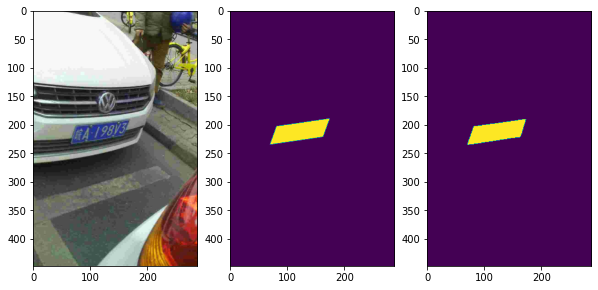

In [49]:
index = 26 # 19 26
img = read_image(images[index],(288,448),cv2.IMREAD_COLOR)
imgRes = np.expand_dims(img, axis=0)
maskRes = read_image(masks[index],(288,448),cv2.IMREAD_GRAYSCALE)
rgbImage = img[:,:,::-1]

# Predict
predRes = model.predict(imgRes)
predRes[predRes < 0.5] = 0
predRes[predRes >= 0.5] = 255

fig = plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.imshow(rgbImage)
plt.subplot(1,3,2)
plt.imshow(maskRes)
plt.subplot(1,3,3)
plt.imshow(predRes[0])

['A', 'U', '9', '8', 'V', '3']


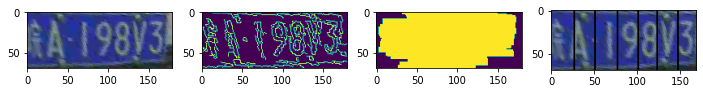

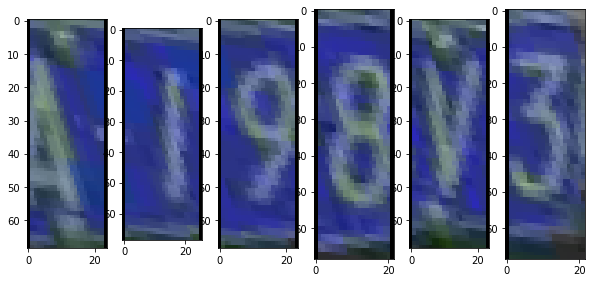

In [50]:
[characters,segResult,resultMaps,segImg,perspective,canny,opening] = plate_characters(img,model,model_classification)
segResult = segResult[:,:,::-1]
for index in range(0,len(segImg)):
    segImg[index] = segImg[index][:,:,::-1]
fig = plt.figure(figsize=(12, 12))

plt.subplot(1,4,1)
plt.imshow(perspective[:,:,::-1])

plt.subplot(1,4,2)
plt.imshow(canny)

plt.subplot(1,4,3)
plt.imshow(opening)

plt.subplot(1,4,4)
plt.imshow(segResult)

fig = plt.figure(figsize=(10, 6))
for index,item in enumerate(segImg):
    plt.subplot(1,len(segImg),index+1)
    plt.imshow(item)
print(characters)

In [ ]:
print(resultMaps[1])
plt.imshow(segImg[1])

In [ ]:
plt.imshow(predRes[0])

def getBoundingBoxFromMask(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [ ]:
img = cv2.resize(imgRes[0],(720,1160),interpolation = cv2.INTER_NEAREST)
pred = cv2.resize(predRes[0],(720,1160),interpolation = cv2.INTER_NEAREST)

img = img.astype(np.uint8)
pred = pred.astype(np.uint8)

contours,_ = cv2.findContours(pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

approx = cv2.approxPolyDP(contours[0], 0.07 * cv2.arcLength(contours[0], True), True)
box = np.squeeze(approx, axis=1)

heigth = 70
width = 180

pt2 = np.float32([[0,0], [width,0], [0,heigth], [width,heigth]])

if box[0][0] < box[2][0]:
    pt12 = np.float32([box[0],box[3],box[1],box[2]])
else:
    pt12 = np.float32([box[1],box[0],box[2],box[3]])
    

f = cv2.getPerspectiveTransform(pt12,pt2)
f2 = cv2.warpPerspective(img,f,(width,heigth))


gray = cv2.cvtColor(f2,cv2.COLOR_BGR2GRAY)
# gray = f2[:,:,2]
# gray = cv2.bilateralFilter(gray,11,17,17)
canny = cv2.Canny(gray,40,200)
# lines = cv2.HoughLinesP(canny,1,np.pi/180,10, maxLineGap=150)

lines = cv2.HoughLinesP(canny,0.001,np.pi/180,3, minLineLength=40, maxLineGap=180)

# if lines is None:
#     break


hough = np.zeros((heigth,width), np.uint8)
hough = canny.copy()

if lines is not None:
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(hough,(x1,y1),(x2,y2),(255),1)
            

kernel = np.ones((int(heigth * 0.1)), dtype=np.uint8) * 255

opening = cv2.morphologyEx(hough, cv2.MORPH_OPEN, kernel)

boxop = getBoundingBoxFromMask(opening).astype(int)

result = f2[boxop[0]:boxop[2],boxop[1]:boxop[3]]

if not result.any():
    result = f2.copy()
resultSeg = result.copy()

he, wi,dm = resultSeg.shape
div = int(wi/7)

divs = [i * div + 5 for i in range(1,7)]
divs[0] = divs[0] - 5
divs[1] = divs[1] - 5
divs[-2] = divs[-2] - 5
divs[-1] = divs[-1] - 5


for i in divs:
    resultSeg[:,i-1:i+1] = 0

In [ ]:
rr = imgRes[0] * 255
rr = rr.astype(np.uint8)
print(np.unique(rr))
plt.imshow(rr)